In [1]:

""" This Py3 code solves the Extended Shallow Water Equations using the Maximum-Entropy
    velocity profile to estimate basal shear stress and energy diffusion terms """

' This Py3 code solves the Extended Shallow Water Equations using the Maximum-Entropy\n    velocity profile to estimate basal shear stress and energy diffusion terms '

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy import interpolate
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['font.size'] = 12
plt.rc('axes', labelsize=20) 
plt.set_cmap('coolwarm')

<Figure size 432x288 with 0 Axes>

In [3]:
def diff_term():
    #setting the same resolution as the OpenFOAM simulations
    dz = 1/160
    zz = np.arange(0,161,1)/160
    r = np.arange(20,1.2,-0.1)
    ediffEnt = r*0
    chi2Ent = r*0
    tauzEnt = r*0
    for i in range(0,r.shape[0]):
        #using maximum entropy solution branch in which \lambda = 0
        uEnt = 1 - (1-zz)**r[i]
        uEnt /= np.trapz(uEnt)*dz
        chi2Ent[i] = np.trapz(uEnt**2)*dz 
        ediffEnt[i] = np.trapz((uEnt[1:]-uEnt[0:-1])**2)/dz
        tauzEnt[i] = (uEnt[2]-uEnt[0])/(2*dz)
    #plt.plot(chi2Ent,r)
    #plt.pause(10000)
    return tauzEnt, ediffEnt, chi2Ent, r

In [4]:
Q = 1 #mass flow rate
g_x = 0.25 #horizontal component of gravity
g_z = 0.25#vertical component of gravity
U = 1.843
H = 0.541

#non dimensionalising g:
Fr = U/np.sqrt(g_z*H)
print('Froude')
print(Fr**2)
g_x *= H/U**2 
g_z *= H/U**2 
""" g_x = g_x/Fr**2
g_z = g_z/Fr**2 """

nu = 1e-2 #kinematic viscosity

Re = U*H/nu
print('Reynolds')
print(Re)

Re1 = 1/Re

dx = (1/100)/H #grid scale
L = 15 #domain length


p = 2.5 #power law for chi2/chi3
chi0 = 1.00
xx = np.arange(0,L,dx) - dx #grid
xxd = np.arange(0,2000*dx,dx)-10/H
xxOF = 0.8*(np.arange(0,20,1/80)-10)/H

#initializing vector of primatives:
W = np.zeros((3,xx.shape[0]))


#generating non-sonservative terms interpolation functions
Enttauzz, Entediff, Entchi2, rEnt = diff_term()


#number of grid points away from the discontinuity to start the simulation:
N_start = 800 #+ 10 
#the reason we may wish to change this is because at the discontinuity, OpenFOAM does
#not perfectly conserve mass, there is instead a ~0.5% error, which can be eliminated by
#offsetting the start of the ESWE simulation by 10 grid points or so.
#The ESWE solution still gives reasonable results when N_start = 0.

discont = 0 #number of grid points until the discontinuity

#using initial conditions from OpenFOAM simulation
W[0,:] = 1
W[1,:] = 1
W[2,:] = 1.0005
#W[0,1] = EnthOF[discont + N_start ]

#vector of non-conservative terms:
Tau = np.zeros((3,1))

#solving
for i in range(2,xx.shape[0]):
    #populating vector of non-conservative terms
    Tau[0,0] = 0
    
    #using interpolation from the maximum entropy velocity profile to find basal shear stress and energy diffusion


    Tau[1,0] = 0 + g_x*W[0,i-1] - 1*Re1*(W[1,i-1]/W[0,i-1])*np.interp(W[2,i-1],Entchi2,Enttauzz) 
    Tau[2,0] = 0 + 2*g_x*W[1,i-1]*W[0,i-1] - 2*Re1*(W[1,i-1]*W[1,i-1]/W[0,i-1])*np.interp(W[2,i-1],Entchi2,Entediff) 


    #building Flux matrix such that:
    #A(W)*dW/dx = Tau
    h = W[0,i-1] + 0
    u = W[1,i-1] + 0
    chi_2 = W[2,i-1]  + 0


    A = np.matrix([[u, chi_2*u**2 + 1.0*g_z*h, chi_2**p*u**3 + 4*g_z*h*u], [h, 2*chi_2*h*u, 3*chi_2**p*h*u**2 + 2*g_z*h**2], [0, h*u**2, chi_2**p*h*p*u**3/chi_2]]).transpose()
    B = np.zeros((3,3))
    B[1,0] = 0.5*Re1
    B[2,0] = 0.5*Re1
    B[2,1] = -0.5*chi_2*Re1
    B *= 0
    A /= dx
    B /= dx**2
    
    #solving explicit Euler
    RHS = Tau + np.matmul(B,W[:,i-2:i-1] - 2*W[:,i-1:i]) + np.matmul(A,W[:,i-1:i])
    W[:,i:i+1] = np.linalg.solve(A - B, RHS)

#parameters for Tsang Mode







Froude
25.11385582255083
Reynolds
99.7063


Text(0, 0.5, '$\\chi_2$')

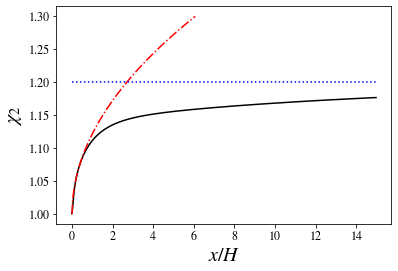

In [5]:
Q = 0.99
c = 1.72

#Tsang Model
chi2Tsang = 1 + c*Re**(-0.5)*(xx/2)**(0.5)
chi2Tsang[chi2Tsang>1.3] = np.nan

plt.plot(xx,W[2,:],color = 'k')
plt.plot(xx,chi2Tsang,'-.', color = 'r')
plt.plot(xx,W[0,:]*0+1.2,':', color = 'b')
plt.xlabel('$x/H$')
plt.ylabel('$\\chi_2$')

Text(0, 0.5, '$\\bar{u}/U$')

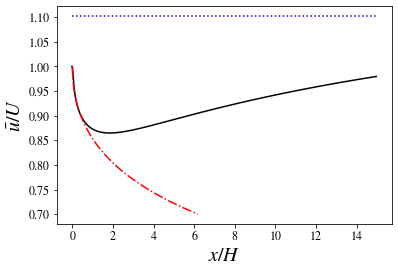

In [6]:
#plotting mean velocity
plt.plot(xx,W[1,:],color = 'k')

chi2Tsang = 1/(1 + c*Re**(-0.5)*(xx)**(0.5))
chi2Tsang[chi2Tsang<0.7] = np.nan

plt.plot(xx,chi2Tsang,'-.', color = 'r')

plt.plot(xx,W[0,:]*0+ 1/(Q*3*Fr**2/Re)**(1/3)      ,':', color = 'b')
plt.xlabel('$x/H$')
plt.ylabel('$\\bar{u}/U$')



Text(0, 0.5, '$h/H$')

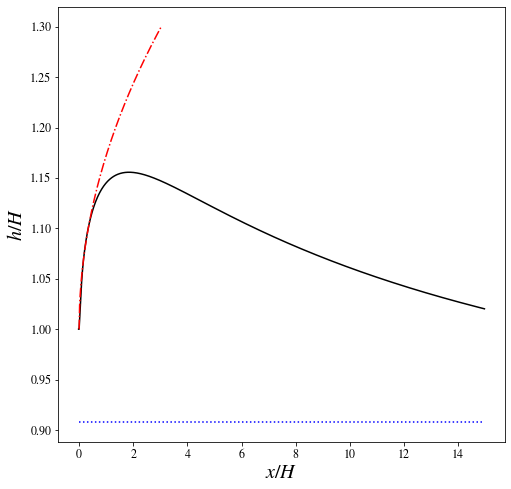

In [7]:
#plotting flow depth

plt.figure(figsize=(8, 8))
c = 1.72
plt.plot(xx,W[0,:],color = 'k')

chi2Tsang = (1 + c*Re**(-0.5)*(xx)**(0.5))
chi2Tsang[chi2Tsang>1.3] = np.nan

plt.plot(xx,chi2Tsang,'-.', color = 'r')
plt.plot(xx,W[0,:]*0+ (Q*3*Fr**2/Re)**(1/3)      ,':', color = 'b')
plt.xlabel('$x/H$')
plt.ylabel('$h/H$')